In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/train/present/UID_35_10_3_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_6_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_7_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_2_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_4_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_8_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_11_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_2_all.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
train_path = "/content/data/data/train"
val_path = "/content/data/data/validation"
test_path = "/content/data/data/test"

In [ ]:
IMAGE_SIZE = [224,224]

In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale=1.0 / 255,
    rotation_range=30,           # Rotate images by up to 30 degrees
    width_shift_range=0.05,       # Translate horizontally by 20% of the width
    height_shift_range=0.05,      # Translate vertically by 20% of the height
    shear_range=0.1,             # Apply shear transformation
    zoom_range=0.1,              # Random zoom by up to 20%
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2],)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode = 'categorical')

val_set = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='categorical')

Found 9616 images belonging to 2 classes.
Found 2062 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.


In [ ]:

from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# Xception

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [ ]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head
model6 = Model(inputs=base.input, outputs=head)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model6.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [ ]:
hist6 = model6.fit(train_set, validation_data=val_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(val_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 266s 362ms/step - accuracy: 0.8358 - f1_m: 0.8358 - loss: 0.3941 - precision_m: 0.8358 - recall_m: 0.8358 - val_accuracy: 0.5994 - val_f1_m: 0.5993 - val_loss: 2.8216 - val_precision_m: 0.5993 - val_recall_m: 0.5993 - learning_rate: 0.0010
Epoch 2/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 241s 366ms/step - accuracy: 0.8934 - f1_m: 0.8934 - loss: 0.2620 - precision_m: 0.8934 - recall_m: 0.8934 - val_accuracy: 0.6634 - val_f1_m: 0.6636 - val_loss: 0.9012 - val_precision_m: 0.6636 - val_recall_m: 0.6636 - learning_rate: 0.0010
Epoch 3/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 218s 362ms/step - accuracy: 0.9120 - f1_m: 0.9120 - loss: 0.2299 - precision_m: 0.9120 - recall_m: 0.9120 - val_accuracy: 0.8710 - val_f1_m: 0.8709 - val_loss: 0.3290 - val_precision_m: 0.8709 - val_recall_m: 0.8709 - learning_rate: 0.0010
Epoch 4/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 208s 346ms/step - accuracy: 0.9198 - f1_m: 0.9198 - loss: 0.2097 - precision_m: 0.9198 - recall_m: 0.9198 - val_accuracy

In [ ]:
from google.colab import files
model6.save(f"/content/drive/MyDrive/{'Xception5'}.h5")
#files.download(f"/content/drive/MyDrive/Xception.h5")  # For .h5 file


In [ ]:
scores = model6.evaluate(test_set)
storeResults("Xception", scores[1], scores[2], scores[3], scores[4])

129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9686 - f1_m: 0.9686 - loss: 0.0874 - precision_m: 0.9686 - recall_m: 0.9686


In [ ]:
 #previous test accuracy: 92ms/step - accuracy: 0.9523 - f1_m: 0.9523 - loss: 0.1217 - precision_m: 0.9523 - recall_m: 0.9523

In [ ]:
import json
# Save training history to a JSON file
history_dict = hist6.history
with open(f"/content/drive/MyDrive/{'Xception5'}_history.json", "w") as f:
    json.dump(history_dict, f)


In [ ]:
print(hist6.history['accuracy'][-1])
print(hist6.history['precision_m'][-1])
print(hist6.history['recall_m'][-1])
print(hist6.history['f1_m'][-1])


0.9858568906784058
0.9858568906784058
0.9858568906784058
0.9858568906784058


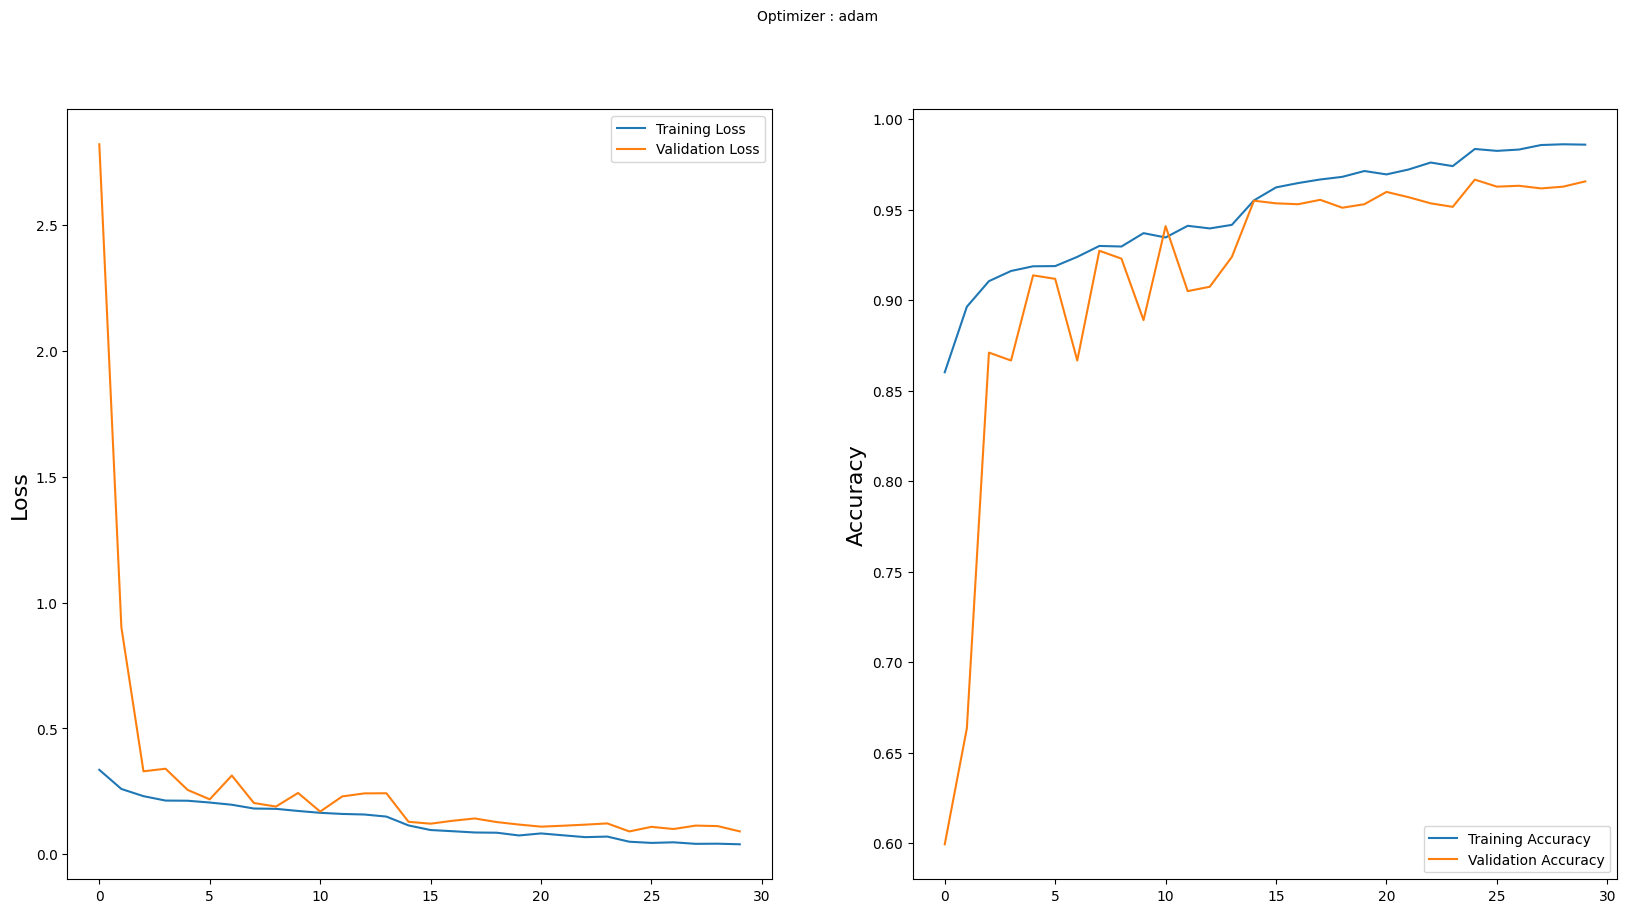

In [ ]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()